# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
# data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0k/60.0k [00:12<00:00, 4.66kFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

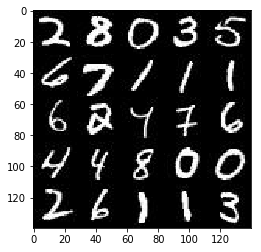

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

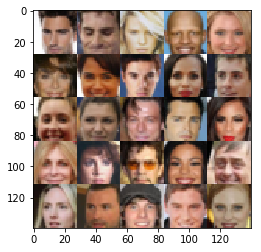

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.9.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='inputs_z')
    learn_rate = tf.placeholder(tf.float32)
    return inputs_real, inputs_z, learn_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2, dropout=0.5):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        do2 = tf.layers.dropout(inputs=relu2, rate=dropout, training=False)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        do3 = tf.layers.dropout(inputs=relu3, rate=dropout, training=False)

        
#         flat = tf.reshape(relu3, (-1, 4*4*256))
        flat = tf.contrib.layers.flatten(do3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, dropout=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3,3,512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)

        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        x2 = tf.layers.dropout(inputs=x2, rate=dropout, training=is_train)



        
        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='valid')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        x3 = tf.layers.dropout(inputs=x3, rate=dropout, training=is_train)

        
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        logits = tf.reshape(logits, (-1, 28, 28, out_channel_dim))
        out = tf.tanh(logits)


    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    print_step = 20
    show_gen_step = 100
    alpha = 0.2
    _, width, height, img_channels = data_shape
    losses = []
    step = 0
    
    inputs_real, inputs_z, learn_rate = model_inputs(width, height, img_channels, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, img_channels, alpha=alpha)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                step +=1
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z : batch_z, learn_rate: learning_rate})
                _ = sess.run(g_train_opt, feed_dict={inputs_real: batch_images, inputs_z : batch_z, learn_rate: learning_rate})
                
                if step % print_step == 0 :
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                if step % show_gen_step == 0 :
                    show_generator_output(sess, 10, inputs_z, img_channels, data_image_mode)
                    
        print("Training Finished")
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9769... Generator Loss: 4.6039
Epoch 1/2... Discriminator Loss: 2.0208... Generator Loss: 0.1891
Epoch 1/2... Discriminator Loss: 1.1826... Generator Loss: 1.1464
Epoch 1/2... Discriminator Loss: 0.0993... Generator Loss: 2.7631
Epoch 1/2... Discriminator Loss: 1.0147... Generator Loss: 0.7696


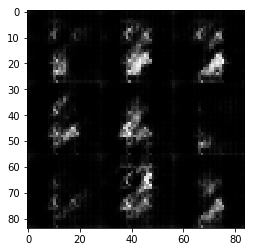

Epoch 1/2... Discriminator Loss: 4.0676... Generator Loss: 5.6508
Epoch 1/2... Discriminator Loss: 1.9169... Generator Loss: 4.3447
Epoch 1/2... Discriminator Loss: 0.4396... Generator Loss: 1.6108
Epoch 1/2... Discriminator Loss: 1.8292... Generator Loss: 0.2924
Epoch 1/2... Discriminator Loss: 1.3882... Generator Loss: 6.0211


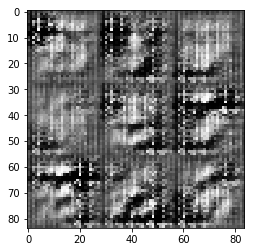

Epoch 1/2... Discriminator Loss: 0.6489... Generator Loss: 1.8136
Epoch 1/2... Discriminator Loss: 0.2134... Generator Loss: 1.8155
Epoch 1/2... Discriminator Loss: 2.9895... Generator Loss: 4.5810
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 0.6646
Epoch 1/2... Discriminator Loss: 0.9281... Generator Loss: 0.6666


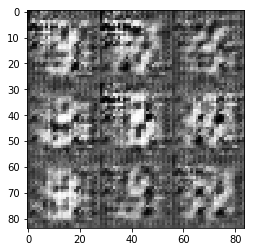

Epoch 1/2... Discriminator Loss: 0.3836... Generator Loss: 1.7992
Epoch 1/2... Discriminator Loss: 0.0620... Generator Loss: 7.6058
Epoch 1/2... Discriminator Loss: 2.2715... Generator Loss: 0.2051
Epoch 1/2... Discriminator Loss: 0.9027... Generator Loss: 1.5726
Epoch 1/2... Discriminator Loss: 0.0821... Generator Loss: 3.5686


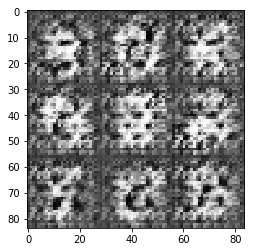

Epoch 1/2... Discriminator Loss: 0.0294... Generator Loss: 6.4694
Epoch 1/2... Discriminator Loss: 0.1188... Generator Loss: 3.2282
Epoch 1/2... Discriminator Loss: 0.0208... Generator Loss: 5.7420
Epoch 1/2... Discriminator Loss: 0.0096... Generator Loss: 5.6910
Epoch 1/2... Discriminator Loss: 0.8348... Generator Loss: 1.3521


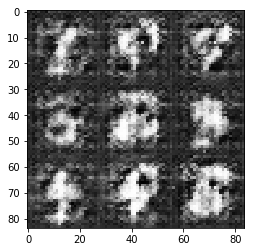

Epoch 1/2... Discriminator Loss: 2.1641... Generator Loss: 0.2142
Epoch 1/2... Discriminator Loss: 0.4842... Generator Loss: 1.1509
Epoch 1/2... Discriminator Loss: 0.1071... Generator Loss: 2.6073
Epoch 1/2... Discriminator Loss: 0.0482... Generator Loss: 3.8501
Epoch 1/2... Discriminator Loss: 0.0224... Generator Loss: 7.4965


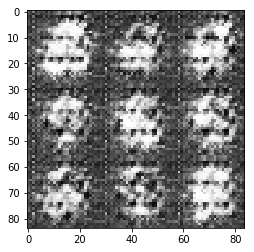

Epoch 1/2... Discriminator Loss: 0.0182... Generator Loss: 5.4528
Epoch 1/2... Discriminator Loss: 0.0507... Generator Loss: 3.9405
Epoch 1/2... Discriminator Loss: 0.0102... Generator Loss: 8.9293
Epoch 1/2... Discriminator Loss: 0.0032... Generator Loss: 8.1630
Epoch 1/2... Discriminator Loss: 0.0039... Generator Loss: 9.0540


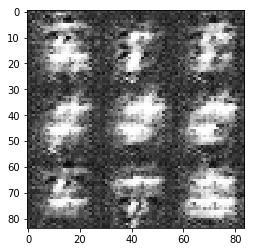

Epoch 1/2... Discriminator Loss: 0.2989... Generator Loss: 2.2072
Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 1.4111
Epoch 1/2... Discriminator Loss: 0.8767... Generator Loss: 3.2127
Epoch 1/2... Discriminator Loss: 0.5069... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 0.3167... Generator Loss: 1.6812


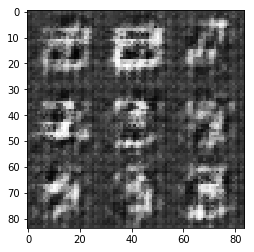

Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 1.3602
Epoch 1/2... Discriminator Loss: 0.5219... Generator Loss: 1.4550
Epoch 1/2... Discriminator Loss: 0.0298... Generator Loss: 4.0943
Epoch 1/2... Discriminator Loss: 0.0088... Generator Loss: 6.1232
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 8.7802


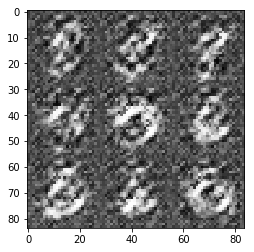

Epoch 1/2... Discriminator Loss: 0.0175... Generator Loss: 5.3755
Epoch 1/2... Discriminator Loss: 0.0206... Generator Loss: 5.1677
Epoch 1/2... Discriminator Loss: 0.0087... Generator Loss: 5.5812
Epoch 1/2... Discriminator Loss: 0.0064... Generator Loss: 7.0755
Epoch 1/2... Discriminator Loss: 0.0018... Generator Loss: 9.1234


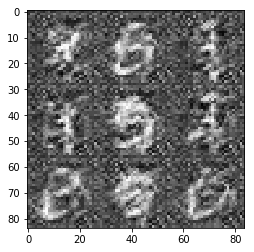

Epoch 1/2... Discriminator Loss: 0.0073... Generator Loss: 9.1715
Epoch 1/2... Discriminator Loss: 0.0405... Generator Loss: 4.8136
Epoch 1/2... Discriminator Loss: 0.3088... Generator Loss: 2.0015
Epoch 1/2... Discriminator Loss: 0.0263... Generator Loss: 4.7283
Epoch 1/2... Discriminator Loss: 0.2951... Generator Loss: 1.9678


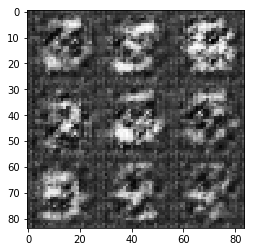

Epoch 1/2... Discriminator Loss: 0.3003... Generator Loss: 1.6887
Epoch 1/2... Discriminator Loss: 0.0149... Generator Loss: 5.8092
Epoch 1/2... Discriminator Loss: 0.0117... Generator Loss: 4.7659
Epoch 1/2... Discriminator Loss: 0.0081... Generator Loss: 6.7963
Epoch 1/2... Discriminator Loss: 0.0156... Generator Loss: 5.0288


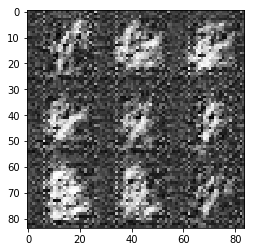

Epoch 1/2... Discriminator Loss: 0.0100... Generator Loss: 5.9545
Epoch 1/2... Discriminator Loss: 0.0070... Generator Loss: 5.7477
Epoch 1/2... Discriminator Loss: 0.0069... Generator Loss: 6.0985
Epoch 1/2... Discriminator Loss: 0.0239... Generator Loss: 5.5081
Epoch 1/2... Discriminator Loss: 0.1226... Generator Loss: 2.8303


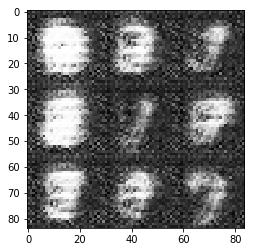

Epoch 1/2... Discriminator Loss: 0.2362... Generator Loss: 7.1033
Epoch 1/2... Discriminator Loss: 0.3004... Generator Loss: 2.0932
Epoch 1/2... Discriminator Loss: 0.3342... Generator Loss: 3.4664
Epoch 1/2... Discriminator Loss: 0.0954... Generator Loss: 2.7456
Epoch 1/2... Discriminator Loss: 0.0423... Generator Loss: 5.1131


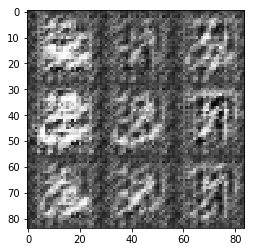

Epoch 1/2... Discriminator Loss: 0.0260... Generator Loss: 4.2477
Epoch 1/2... Discriminator Loss: 0.0136... Generator Loss: 5.3436
Epoch 1/2... Discriminator Loss: 0.0029... Generator Loss: 8.4720
Epoch 1/2... Discriminator Loss: 0.1993... Generator Loss: 2.9657
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 1.0896


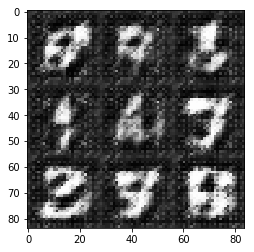

Epoch 1/2... Discriminator Loss: 0.9327... Generator Loss: 2.6673
Epoch 1/2... Discriminator Loss: 0.5071... Generator Loss: 1.5127
Epoch 1/2... Discriminator Loss: 0.6546... Generator Loss: 1.3605
Epoch 1/2... Discriminator Loss: 1.0715... Generator Loss: 1.0337
Epoch 1/2... Discriminator Loss: 0.4040... Generator Loss: 2.5986


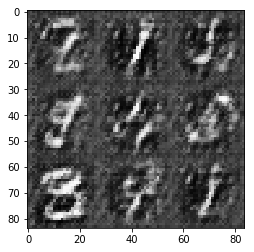

Epoch 1/2... Discriminator Loss: 0.3016... Generator Loss: 2.1999
Epoch 1/2... Discriminator Loss: 0.5666... Generator Loss: 6.2184
Epoch 1/2... Discriminator Loss: 0.3389... Generator Loss: 1.7074
Epoch 1/2... Discriminator Loss: 0.0844... Generator Loss: 3.3859
Epoch 1/2... Discriminator Loss: 0.0909... Generator Loss: 2.5225


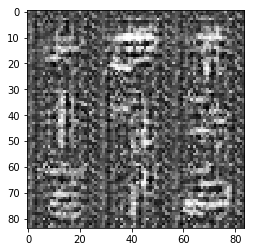

Epoch 1/2... Discriminator Loss: 0.0110... Generator Loss: 6.9753
Epoch 1/2... Discriminator Loss: 0.0051... Generator Loss: 6.9960
Epoch 1/2... Discriminator Loss: 0.0192... Generator Loss: 4.6687
Epoch 1/2... Discriminator Loss: 0.0058... Generator Loss: 6.3603
Epoch 1/2... Discriminator Loss: 0.0106... Generator Loss: 5.7739


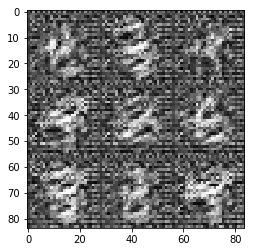

Epoch 1/2... Discriminator Loss: 0.0115... Generator Loss: 5.3276
Epoch 1/2... Discriminator Loss: 0.0226... Generator Loss: 4.8126
Epoch 1/2... Discriminator Loss: 0.0038... Generator Loss: 6.4137
Epoch 2/2... Discriminator Loss: 0.0080... Generator Loss: 5.4577
Epoch 2/2... Discriminator Loss: 0.0067... Generator Loss: 5.4556


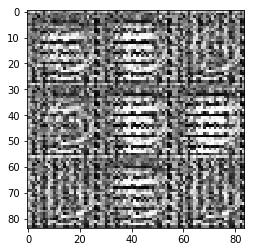

Epoch 2/2... Discriminator Loss: 0.0014... Generator Loss: 7.6564
Epoch 2/2... Discriminator Loss: 0.0210... Generator Loss: 4.5745
Epoch 2/2... Discriminator Loss: 0.0012... Generator Loss: 9.4560
Epoch 2/2... Discriminator Loss: 14.4571... Generator Loss: 0.0000
Epoch 2/2... Discriminator Loss: 0.5042... Generator Loss: 7.5590


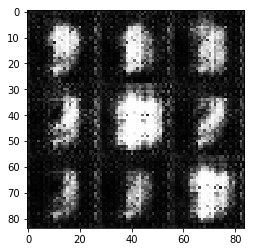

Epoch 2/2... Discriminator Loss: 0.0446... Generator Loss: 4.5939
Epoch 2/2... Discriminator Loss: 0.1921... Generator Loss: 3.3295
Epoch 2/2... Discriminator Loss: 0.1441... Generator Loss: 3.5080
Epoch 2/2... Discriminator Loss: 0.3462... Generator Loss: 2.0046
Epoch 2/2... Discriminator Loss: 0.1599... Generator Loss: 3.1257


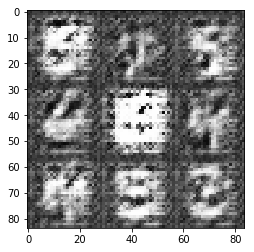

Epoch 2/2... Discriminator Loss: 0.0296... Generator Loss: 5.4970
Epoch 2/2... Discriminator Loss: 0.0202... Generator Loss: 5.8009
Epoch 2/2... Discriminator Loss: 0.0783... Generator Loss: 3.0681
Epoch 2/2... Discriminator Loss: 0.0157... Generator Loss: 5.6004
Epoch 2/2... Discriminator Loss: 0.0051... Generator Loss: 6.3502


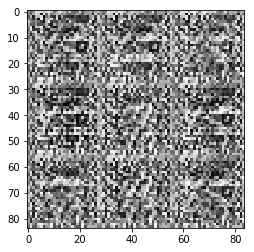

Epoch 2/2... Discriminator Loss: 0.0067... Generator Loss: 5.7283
Epoch 2/2... Discriminator Loss: 0.0017... Generator Loss: 7.7301
Epoch 2/2... Discriminator Loss: 0.0011... Generator Loss: 8.2853
Epoch 2/2... Discriminator Loss: 0.0033... Generator Loss: 11.7770
Epoch 2/2... Discriminator Loss: 0.0281... Generator Loss: 4.6899


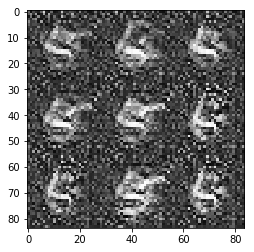

Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 12.0089
Epoch 2/2... Discriminator Loss: 0.0484... Generator Loss: 16.6924
Epoch 2/2... Discriminator Loss: 0.0270... Generator Loss: 4.1731
Epoch 2/2... Discriminator Loss: 0.5444... Generator Loss: 2.0387
Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 6.9645


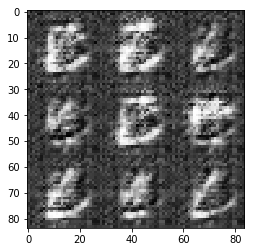

Epoch 2/2... Discriminator Loss: 0.0190... Generator Loss: 4.6867
Epoch 2/2... Discriminator Loss: 0.0093... Generator Loss: 6.5900
Epoch 2/2... Discriminator Loss: 0.0045... Generator Loss: 7.1493
Epoch 2/2... Discriminator Loss: 0.0117... Generator Loss: 5.7543
Epoch 2/2... Discriminator Loss: 0.0028... Generator Loss: 7.5696


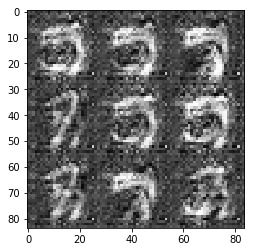

Epoch 2/2... Discriminator Loss: 0.0032... Generator Loss: 6.6823
Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 10.2828
Epoch 2/2... Discriminator Loss: 0.0037... Generator Loss: 9.1358
Epoch 2/2... Discriminator Loss: 0.0058... Generator Loss: 6.2045
Epoch 2/2... Discriminator Loss: 0.0074... Generator Loss: 5.6716


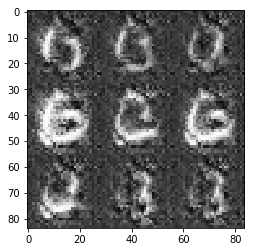

Epoch 2/2... Discriminator Loss: 0.0032... Generator Loss: 10.1532
Epoch 2/2... Discriminator Loss: 0.0060... Generator Loss: 5.6692
Epoch 2/2... Discriminator Loss: 0.0136... Generator Loss: 4.1404
Epoch 2/2... Discriminator Loss: 0.0046... Generator Loss: 7.0860
Epoch 2/2... Discriminator Loss: 0.0041... Generator Loss: 10.2359


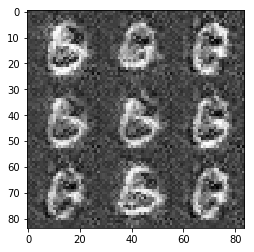

Epoch 2/2... Discriminator Loss: 0.0232... Generator Loss: 5.1496
Epoch 2/2... Discriminator Loss: 0.0677... Generator Loss: 3.9587
Epoch 2/2... Discriminator Loss: 0.2973... Generator Loss: 1.9214
Epoch 2/2... Discriminator Loss: 0.2507... Generator Loss: 1.8662
Epoch 2/2... Discriminator Loss: 0.0404... Generator Loss: 4.1958


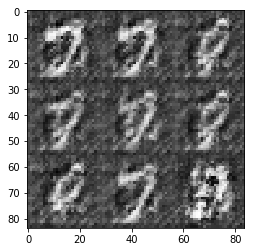

Epoch 2/2... Discriminator Loss: 0.0369... Generator Loss: 4.4975
Epoch 2/2... Discriminator Loss: 0.1805... Generator Loss: 3.1542
Epoch 2/2... Discriminator Loss: 0.1833... Generator Loss: 2.5218
Epoch 2/2... Discriminator Loss: 0.0250... Generator Loss: 4.9550
Epoch 2/2... Discriminator Loss: 0.0082... Generator Loss: 6.7384


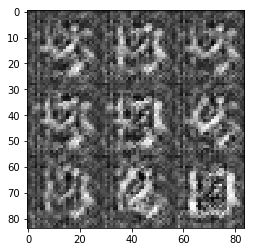

Epoch 2/2... Discriminator Loss: 0.0387... Generator Loss: 4.2671
Epoch 2/2... Discriminator Loss: 0.0074... Generator Loss: 4.7771
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 6.0740
Epoch 2/2... Discriminator Loss: 0.0077... Generator Loss: 5.5837
Epoch 2/2... Discriminator Loss: 0.0065... Generator Loss: 7.4607


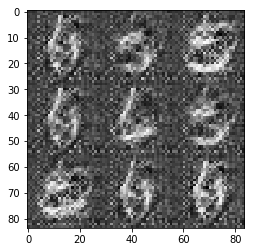

Epoch 2/2... Discriminator Loss: 0.0032... Generator Loss: 6.9561
Epoch 2/2... Discriminator Loss: 0.0026... Generator Loss: 8.2729
Epoch 2/2... Discriminator Loss: 0.0024... Generator Loss: 8.1794
Epoch 2/2... Discriminator Loss: 0.0035... Generator Loss: 6.9640
Epoch 2/2... Discriminator Loss: 0.0020... Generator Loss: 7.6412


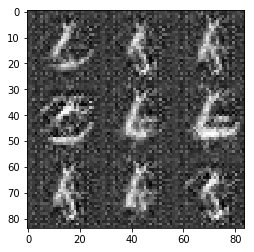

Epoch 2/2... Discriminator Loss: 0.0185... Generator Loss: 9.2454
Epoch 2/2... Discriminator Loss: 0.0102... Generator Loss: 8.5249
Epoch 2/2... Discriminator Loss: 0.0099... Generator Loss: 6.2094
Epoch 2/2... Discriminator Loss: 0.0059... Generator Loss: 9.7177
Epoch 2/2... Discriminator Loss: 0.0031... Generator Loss: 8.2537


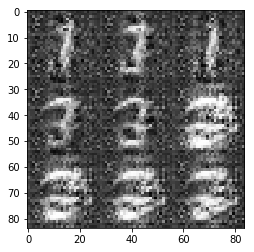

Epoch 2/2... Discriminator Loss: 0.0406... Generator Loss: 4.2044
Epoch 2/2... Discriminator Loss: 0.0009... Generator Loss: 9.8798
Epoch 2/2... Discriminator Loss: 0.0718... Generator Loss: 3.3297
Epoch 2/2... Discriminator Loss: 4.5892... Generator Loss: 21.3956
Epoch 2/2... Discriminator Loss: 0.1859... Generator Loss: 10.2386


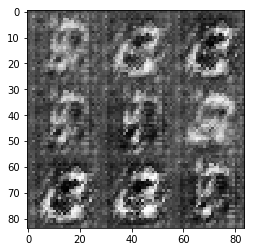

Epoch 2/2... Discriminator Loss: 0.0079... Generator Loss: 5.9927
Epoch 2/2... Discriminator Loss: 0.0879... Generator Loss: 4.0633
Epoch 2/2... Discriminator Loss: 0.0139... Generator Loss: 8.2186
Epoch 2/2... Discriminator Loss: 0.0499... Generator Loss: 9.2496
Epoch 2/2... Discriminator Loss: 0.0265... Generator Loss: 4.8824


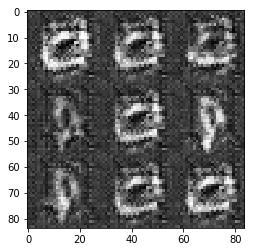

Epoch 2/2... Discriminator Loss: 0.0035... Generator Loss: 8.3997
Epoch 2/2... Discriminator Loss: 0.0054... Generator Loss: 7.0683
Epoch 2/2... Discriminator Loss: 0.0034... Generator Loss: 7.8678
Epoch 2/2... Discriminator Loss: 0.0092... Generator Loss: 5.5363
Epoch 2/2... Discriminator Loss: 0.0019... Generator Loss: 7.1753


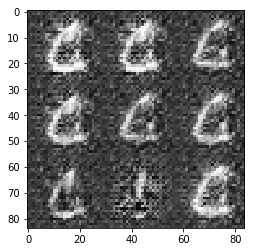

Epoch 2/2... Discriminator Loss: 0.0053... Generator Loss: 6.1680
Epoch 2/2... Discriminator Loss: 0.0307... Generator Loss: 6.4256
Epoch 2/2... Discriminator Loss: 0.1241... Generator Loss: 2.8776
Epoch 2/2... Discriminator Loss: 0.0290... Generator Loss: 6.1686
Epoch 2/2... Discriminator Loss: 0.0975... Generator Loss: 3.4196


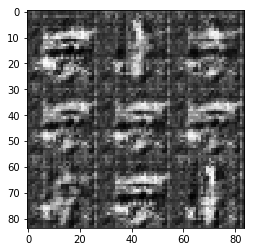

Epoch 2/2... Discriminator Loss: 0.0083... Generator Loss: 6.5093
Epoch 2/2... Discriminator Loss: 0.0045... Generator Loss: 9.1526
Epoch 2/2... Discriminator Loss: 0.0018... Generator Loss: 9.2932
Epoch 2/2... Discriminator Loss: 0.0069... Generator Loss: 8.8854
Epoch 2/2... Discriminator Loss: 0.0063... Generator Loss: 5.3268


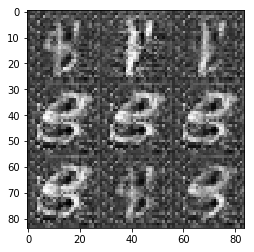

Epoch 2/2... Discriminator Loss: 0.0106... Generator Loss: 7.5278
Epoch 2/2... Discriminator Loss: 0.0014... Generator Loss: 9.8572


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.3453... Generator Loss: 1.7492
Epoch 1/1... Discriminator Loss: 0.1700... Generator Loss: 2.2481
Epoch 1/1... Discriminator Loss: 0.1589... Generator Loss: 10.0101
Epoch 1/1... Discriminator Loss: 0.1871... Generator Loss: 2.5586
Epoch 1/1... Discriminator Loss: 0.0970... Generator Loss: 2.7472


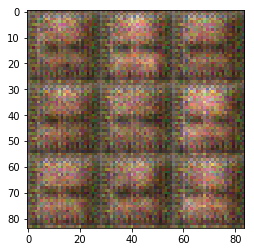

Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 8.5271
Epoch 1/1... Discriminator Loss: 0.7231... Generator Loss: 5.8200
Epoch 1/1... Discriminator Loss: 0.1386... Generator Loss: 2.5573
Epoch 1/1... Discriminator Loss: 0.1227... Generator Loss: 2.7536
Epoch 1/1... Discriminator Loss: 0.0809... Generator Loss: 2.9597


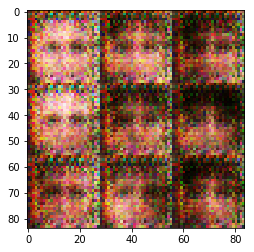

Epoch 1/1... Discriminator Loss: 0.0718... Generator Loss: 3.1090
Epoch 1/1... Discriminator Loss: 0.0563... Generator Loss: 3.6012
Epoch 1/1... Discriminator Loss: 0.0627... Generator Loss: 3.2028
Epoch 1/1... Discriminator Loss: 0.0282... Generator Loss: 4.5297
Epoch 1/1... Discriminator Loss: 0.0392... Generator Loss: 3.8710


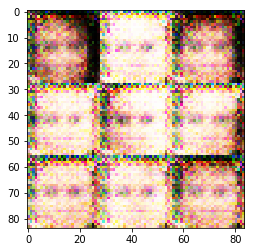

Epoch 1/1... Discriminator Loss: 0.0234... Generator Loss: 4.9299
Epoch 1/1... Discriminator Loss: 0.1231... Generator Loss: 6.3511
Epoch 1/1... Discriminator Loss: 0.0228... Generator Loss: 4.2997
Epoch 1/1... Discriminator Loss: 0.0389... Generator Loss: 3.8884
Epoch 1/1... Discriminator Loss: 0.0367... Generator Loss: 3.8976


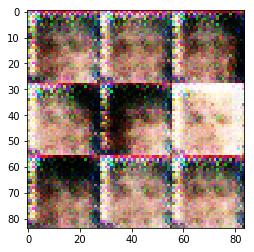

Epoch 1/1... Discriminator Loss: 0.0310... Generator Loss: 4.0703
Epoch 1/1... Discriminator Loss: 0.0255... Generator Loss: 4.3248
Epoch 1/1... Discriminator Loss: 0.0215... Generator Loss: 4.3529
Epoch 1/1... Discriminator Loss: 0.0220... Generator Loss: 4.6751
Epoch 1/1... Discriminator Loss: 0.0377... Generator Loss: 3.8000


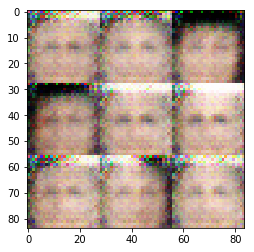

Epoch 1/1... Discriminator Loss: 0.0203... Generator Loss: 4.5158
Epoch 1/1... Discriminator Loss: 0.0262... Generator Loss: 4.9800
Epoch 1/1... Discriminator Loss: 6.6350... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 4.4407
Epoch 1/1... Discriminator Loss: 0.0373... Generator Loss: 4.3687


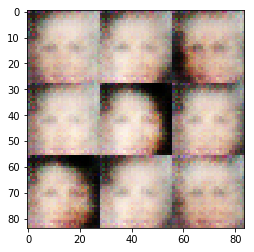

Epoch 1/1... Discriminator Loss: 0.0607... Generator Loss: 4.1286
Epoch 1/1... Discriminator Loss: 0.0941... Generator Loss: 3.5208
Epoch 1/1... Discriminator Loss: 0.0974... Generator Loss: 3.0966
Epoch 1/1... Discriminator Loss: 0.0902... Generator Loss: 2.9083
Epoch 1/1... Discriminator Loss: 0.0421... Generator Loss: 3.9479


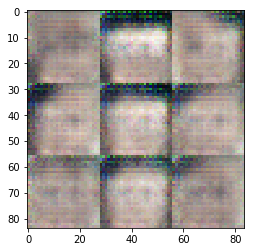

Epoch 1/1... Discriminator Loss: 0.0900... Generator Loss: 3.2062
Epoch 1/1... Discriminator Loss: 0.1081... Generator Loss: 3.3319
Epoch 1/1... Discriminator Loss: 0.0768... Generator Loss: 3.7712
Epoch 1/1... Discriminator Loss: 0.2195... Generator Loss: 1.7235
Epoch 1/1... Discriminator Loss: 0.2397... Generator Loss: 2.2056


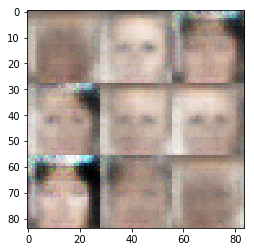

Epoch 1/1... Discriminator Loss: 0.0810... Generator Loss: 3.5351
Epoch 1/1... Discriminator Loss: 0.0787... Generator Loss: 3.1124
Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 0.1609... Generator Loss: 2.6969
Epoch 1/1... Discriminator Loss: 0.2127... Generator Loss: 3.8424


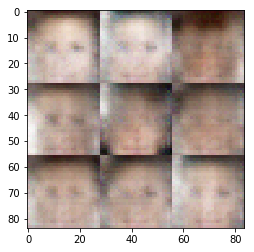

Epoch 1/1... Discriminator Loss: 0.2065... Generator Loss: 3.0685
Epoch 1/1... Discriminator Loss: 0.7511... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 0.3482... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 0.0836... Generator Loss: 3.6589
Epoch 1/1... Discriminator Loss: 0.0451... Generator Loss: 4.8451


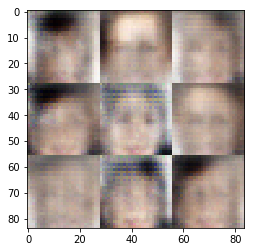

Epoch 1/1... Discriminator Loss: 0.0738... Generator Loss: 3.6183
Epoch 1/1... Discriminator Loss: 0.1656... Generator Loss: 2.4345
Epoch 1/1... Discriminator Loss: 0.1372... Generator Loss: 3.3792
Epoch 1/1... Discriminator Loss: 0.7592... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4774... Generator Loss: 0.3955


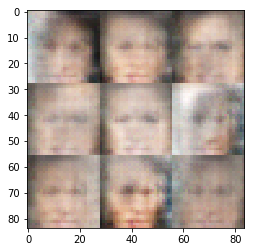

Epoch 1/1... Discriminator Loss: 0.1258... Generator Loss: 2.9697
Epoch 1/1... Discriminator Loss: 0.3988... Generator Loss: 1.4480
Epoch 1/1... Discriminator Loss: 0.1399... Generator Loss: 2.9443
Epoch 1/1... Discriminator Loss: 2.6376... Generator Loss: 0.1295
Epoch 1/1... Discriminator Loss: 0.4917... Generator Loss: 4.0348


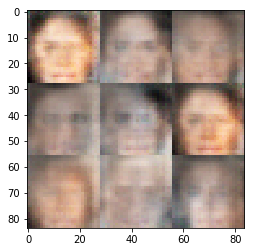

Epoch 1/1... Discriminator Loss: 0.1991... Generator Loss: 2.4145
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 3.6590
Epoch 1/1... Discriminator Loss: 0.1239... Generator Loss: 2.7934
Epoch 1/1... Discriminator Loss: 0.5042... Generator Loss: 1.3013
Epoch 1/1... Discriminator Loss: 0.2765... Generator Loss: 1.9372


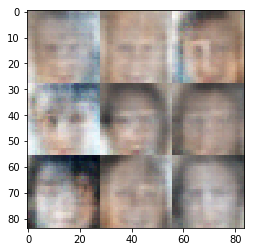

Epoch 1/1... Discriminator Loss: 0.3277... Generator Loss: 4.1477
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 3.8542
Epoch 1/1... Discriminator Loss: 0.3219... Generator Loss: 1.7265
Epoch 1/1... Discriminator Loss: 0.2380... Generator Loss: 2.2821
Epoch 1/1... Discriminator Loss: 0.3351... Generator Loss: 1.6895


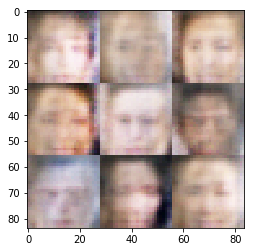

Epoch 1/1... Discriminator Loss: 0.3622... Generator Loss: 1.8566
Epoch 1/1... Discriminator Loss: 0.3539... Generator Loss: 1.6335
Epoch 1/1... Discriminator Loss: 0.1819... Generator Loss: 2.7483
Epoch 1/1... Discriminator Loss: 0.1786... Generator Loss: 2.6994
Epoch 1/1... Discriminator Loss: 0.4017... Generator Loss: 3.3728


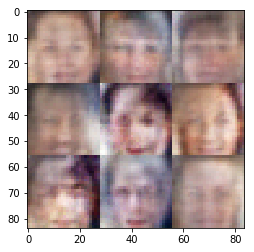

Epoch 1/1... Discriminator Loss: 0.9461... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 0.2967... Generator Loss: 1.7631
Epoch 1/1... Discriminator Loss: 0.5792... Generator Loss: 3.8387
Epoch 1/1... Discriminator Loss: 0.4775... Generator Loss: 2.2259
Epoch 1/1... Discriminator Loss: 1.0805... Generator Loss: 0.6380


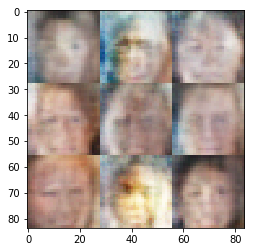

Epoch 1/1... Discriminator Loss: 0.3263... Generator Loss: 1.9238
Epoch 1/1... Discriminator Loss: 0.3630... Generator Loss: 2.0469
Epoch 1/1... Discriminator Loss: 0.3319... Generator Loss: 1.9998
Epoch 1/1... Discriminator Loss: 0.2464... Generator Loss: 2.0354
Epoch 1/1... Discriminator Loss: 0.5238... Generator Loss: 1.1622


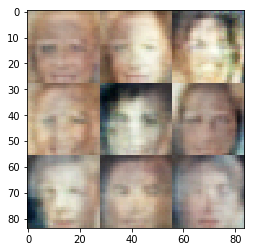

Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 5.2725
Epoch 1/1... Discriminator Loss: 2.1344... Generator Loss: 6.6639
Epoch 1/1... Discriminator Loss: 0.3561... Generator Loss: 1.6098
Epoch 1/1... Discriminator Loss: 0.4659... Generator Loss: 1.6244


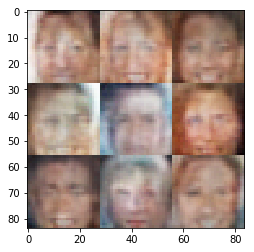

Epoch 1/1... Discriminator Loss: 0.3702... Generator Loss: 1.7700
Epoch 1/1... Discriminator Loss: 0.6646... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.5181... Generator Loss: 1.1050
Epoch 1/1... Discriminator Loss: 0.3033... Generator Loss: 2.4335
Epoch 1/1... Discriminator Loss: 0.4372... Generator Loss: 1.6932


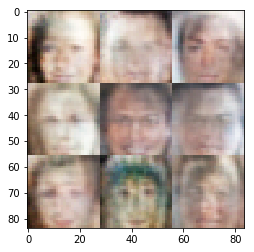

Epoch 1/1... Discriminator Loss: 0.3690... Generator Loss: 1.5801
Epoch 1/1... Discriminator Loss: 0.8738... Generator Loss: 3.8038
Epoch 1/1... Discriminator Loss: 0.7932... Generator Loss: 3.6210
Epoch 1/1... Discriminator Loss: 0.3947... Generator Loss: 1.8095
Epoch 1/1... Discriminator Loss: 0.3968... Generator Loss: 2.9294


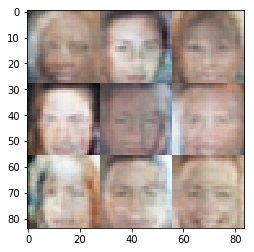

Epoch 1/1... Discriminator Loss: 0.6877... Generator Loss: 1.0201
Epoch 1/1... Discriminator Loss: 0.5499... Generator Loss: 3.8094
Epoch 1/1... Discriminator Loss: 0.4551... Generator Loss: 3.4263
Epoch 1/1... Discriminator Loss: 0.2694... Generator Loss: 2.3236
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 3.0678


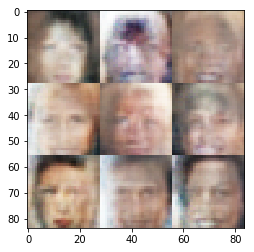

Epoch 1/1... Discriminator Loss: 0.6950... Generator Loss: 3.5287
Epoch 1/1... Discriminator Loss: 0.4271... Generator Loss: 1.4377
Epoch 1/1... Discriminator Loss: 0.3987... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 0.2841... Generator Loss: 1.9080
Epoch 1/1... Discriminator Loss: 0.3268... Generator Loss: 1.8023


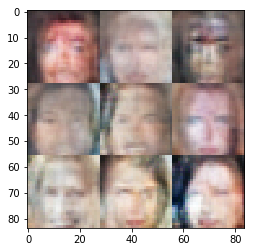

Epoch 1/1... Discriminator Loss: 0.5611... Generator Loss: 2.4534
Epoch 1/1... Discriminator Loss: 0.4079... Generator Loss: 1.3398
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 0.4690... Generator Loss: 1.7871
Epoch 1/1... Discriminator Loss: 0.4075... Generator Loss: 1.5727


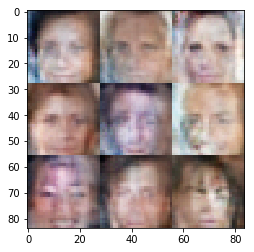

Epoch 1/1... Discriminator Loss: 0.3459... Generator Loss: 1.7540
Epoch 1/1... Discriminator Loss: 0.6329... Generator Loss: 1.2278
Epoch 1/1... Discriminator Loss: 0.3383... Generator Loss: 2.0831
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 1.8506
Epoch 1/1... Discriminator Loss: 0.2607... Generator Loss: 2.5873


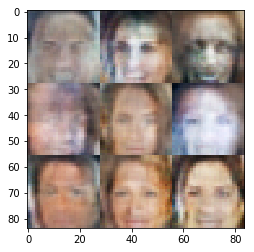

Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.2397
Epoch 1/1... Discriminator Loss: 2.4113... Generator Loss: 3.5403
Epoch 1/1... Discriminator Loss: 0.4754... Generator Loss: 1.4925
Epoch 1/1... Discriminator Loss: 0.3950... Generator Loss: 2.0054
Epoch 1/1... Discriminator Loss: 0.3725... Generator Loss: 1.5714


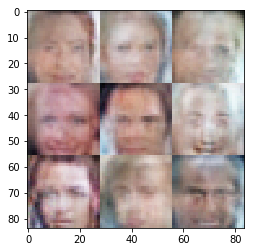

Epoch 1/1... Discriminator Loss: 0.3302... Generator Loss: 2.2345
Epoch 1/1... Discriminator Loss: 0.3280... Generator Loss: 2.6171
Epoch 1/1... Discriminator Loss: 0.4093... Generator Loss: 1.6432
Epoch 1/1... Discriminator Loss: 0.3886... Generator Loss: 1.8776
Epoch 1/1... Discriminator Loss: 0.6815... Generator Loss: 2.4081


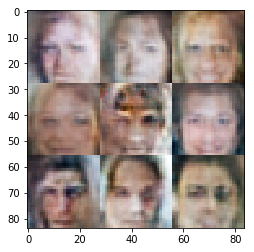

Epoch 1/1... Discriminator Loss: 0.3114... Generator Loss: 1.9532
Epoch 1/1... Discriminator Loss: 0.6262... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 0.2784... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 0.6215
Epoch 1/1... Discriminator Loss: 0.3938... Generator Loss: 1.4947


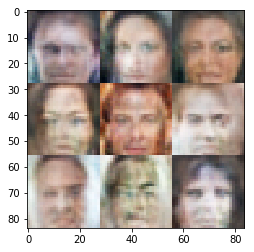

Epoch 1/1... Discriminator Loss: 0.4122... Generator Loss: 2.3527
Epoch 1/1... Discriminator Loss: 0.5644... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 0.5088... Generator Loss: 1.1661
Epoch 1/1... Discriminator Loss: 2.4915... Generator Loss: 4.9406
Epoch 1/1... Discriminator Loss: 0.4806... Generator Loss: 1.8407


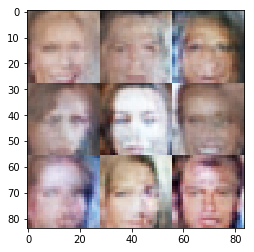

Epoch 1/1... Discriminator Loss: 0.3460... Generator Loss: 2.1776
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.0390
Epoch 1/1... Discriminator Loss: 1.1540... Generator Loss: 3.5895
Epoch 1/1... Discriminator Loss: 0.4301... Generator Loss: 2.4571
Epoch 1/1... Discriminator Loss: 0.3942... Generator Loss: 1.7269


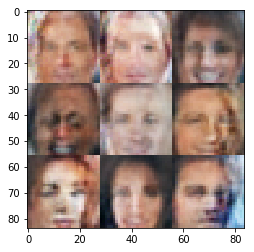

Epoch 1/1... Discriminator Loss: 0.4032... Generator Loss: 2.2371
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 2.9387
Epoch 1/1... Discriminator Loss: 0.3058... Generator Loss: 2.7159
Epoch 1/1... Discriminator Loss: 0.5687... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 0.3191... Generator Loss: 2.2370


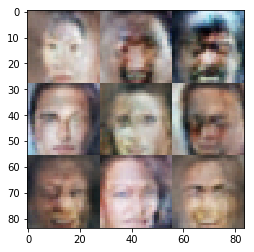

Epoch 1/1... Discriminator Loss: 0.4650... Generator Loss: 2.7105
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 2.8037
Epoch 1/1... Discriminator Loss: 0.6239... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 0.2822... Generator Loss: 2.0464
Epoch 1/1... Discriminator Loss: 0.3985... Generator Loss: 1.1940


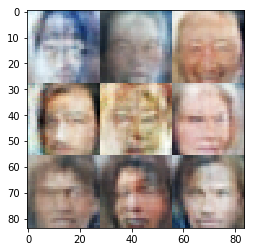

Epoch 1/1... Discriminator Loss: 0.4896... Generator Loss: 2.8039
Epoch 1/1... Discriminator Loss: 0.3984... Generator Loss: 2.1622
Epoch 1/1... Discriminator Loss: 0.5256... Generator Loss: 1.5585
Epoch 1/1... Discriminator Loss: 0.3118... Generator Loss: 2.1901
Epoch 1/1... Discriminator Loss: 0.3573... Generator Loss: 1.9679


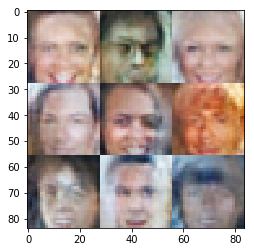

Epoch 1/1... Discriminator Loss: 0.4412... Generator Loss: 1.6167
Epoch 1/1... Discriminator Loss: 0.2249... Generator Loss: 2.5700
Epoch 1/1... Discriminator Loss: 0.2185... Generator Loss: 2.1132
Epoch 1/1... Discriminator Loss: 0.5080... Generator Loss: 1.2620
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 0.6759


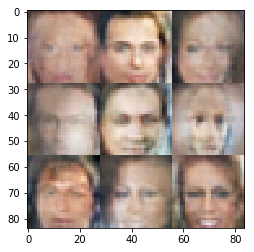

Epoch 1/1... Discriminator Loss: 0.2428... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 0.5081... Generator Loss: 1.4197
Epoch 1/1... Discriminator Loss: 0.6158... Generator Loss: 2.4737
Epoch 1/1... Discriminator Loss: 0.5299... Generator Loss: 1.0081
Epoch 1/1... Discriminator Loss: 0.2878... Generator Loss: 1.9455


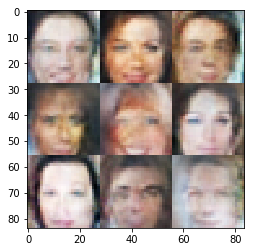

Epoch 1/1... Discriminator Loss: 0.5660... Generator Loss: 1.1007
Epoch 1/1... Discriminator Loss: 0.5046... Generator Loss: 1.3771
Epoch 1/1... Discriminator Loss: 0.5603... Generator Loss: 2.0135
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 1.6090
Epoch 1/1... Discriminator Loss: 0.4629... Generator Loss: 1.5181


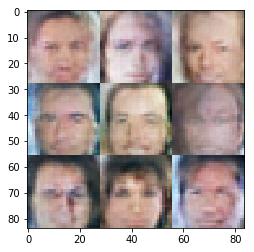

Epoch 1/1... Discriminator Loss: 1.1466... Generator Loss: 0.4584
Epoch 1/1... Discriminator Loss: 0.8960... Generator Loss: 4.1290
Epoch 1/1... Discriminator Loss: 0.4328... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.3586... Generator Loss: 1.5457
Epoch 1/1... Discriminator Loss: 0.2975... Generator Loss: 1.7038


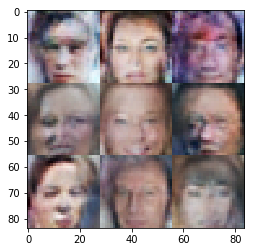

Epoch 1/1... Discriminator Loss: 1.0313... Generator Loss: 0.5449
Epoch 1/1... Discriminator Loss: 0.1858... Generator Loss: 2.8309
Epoch 1/1... Discriminator Loss: 1.4843... Generator Loss: 0.3152
Epoch 1/1... Discriminator Loss: 0.3545... Generator Loss: 2.0766
Epoch 1/1... Discriminator Loss: 0.3207... Generator Loss: 1.7171


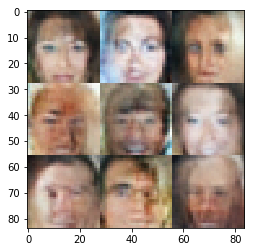

Epoch 1/1... Discriminator Loss: 0.2795... Generator Loss: 1.9475
Epoch 1/1... Discriminator Loss: 0.3045... Generator Loss: 1.6406
Epoch 1/1... Discriminator Loss: 0.8411... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 0.7212... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 0.3927... Generator Loss: 2.2550


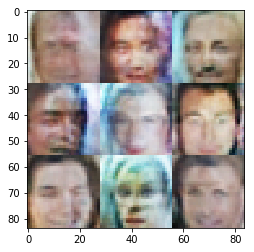

Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 2.1876
Epoch 1/1... Discriminator Loss: 1.3052... Generator Loss: 0.4288
Epoch 1/1... Discriminator Loss: 0.2779... Generator Loss: 1.7742
Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 2.6633
Epoch 1/1... Discriminator Loss: 0.4391... Generator Loss: 1.4312


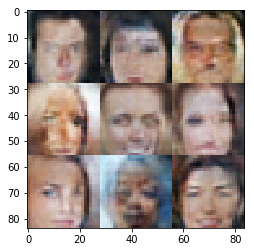

Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.3901
Epoch 1/1... Discriminator Loss: 0.7114... Generator Loss: 0.9104
Epoch 1/1... Discriminator Loss: 0.4208... Generator Loss: 1.4935
Epoch 1/1... Discriminator Loss: 0.3340... Generator Loss: 2.6200
Epoch 1/1... Discriminator Loss: 0.5756... Generator Loss: 0.9659


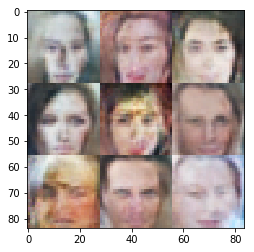

Epoch 1/1... Discriminator Loss: 0.5111... Generator Loss: 3.0364
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 1.6341
Epoch 1/1... Discriminator Loss: 0.4534... Generator Loss: 1.2023
Epoch 1/1... Discriminator Loss: 0.3009... Generator Loss: 1.6964
Epoch 1/1... Discriminator Loss: 0.9968... Generator Loss: 0.6073


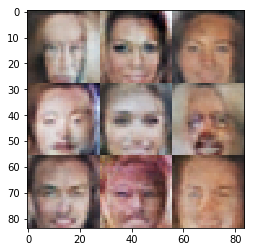

Epoch 1/1... Discriminator Loss: 0.3825... Generator Loss: 1.5095
Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 1.3710
Epoch 1/1... Discriminator Loss: 0.4594... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 0.2615... Generator Loss: 2.2331
Epoch 1/1... Discriminator Loss: 0.5566... Generator Loss: 1.0271


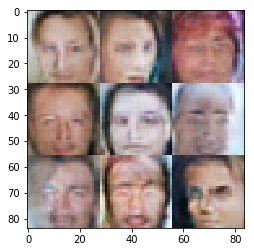

Epoch 1/1... Discriminator Loss: 0.5446... Generator Loss: 0.9708
Epoch 1/1... Discriminator Loss: 0.4523... Generator Loss: 3.3325
Epoch 1/1... Discriminator Loss: 0.4802... Generator Loss: 1.2968
Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 0.7517... Generator Loss: 0.9118


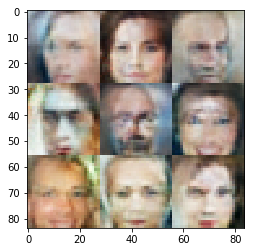

Epoch 1/1... Discriminator Loss: 0.4219... Generator Loss: 1.9206
Epoch 1/1... Discriminator Loss: 0.3007... Generator Loss: 1.9997
Epoch 1/1... Discriminator Loss: 0.3060... Generator Loss: 1.4851
Epoch 1/1... Discriminator Loss: 0.1965... Generator Loss: 2.0797
Epoch 1/1... Discriminator Loss: 0.6687... Generator Loss: 0.8560


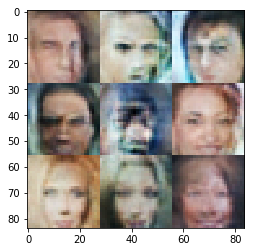

Epoch 1/1... Discriminator Loss: 0.3783... Generator Loss: 1.3370
Epoch 1/1... Discriminator Loss: 0.7063... Generator Loss: 0.6952


KeyboardInterrupt: 

In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.03


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.